#### 📚 Importar bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow as pa

#### 💾 Carga de Data Set

In [2]:
energy_df = pd.read_excel('../data/external/Energia_Demo.xlsx')

### 📊 Descripción de los datos

In [3]:
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569087 entries, 0 to 569086
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   kWh E        569087 non-null  float64       
 1   kVARh        569087 non-null  float64       
 2   Fecha HR     569087 non-null  datetime64[ns]
 3   NombreDia    569087 non-null  object        
 4   MES          569087 non-null  object        
 5   Año          569087 non-null  int64         
 6   HORA         569087 non-null  int64         
 7   MINUTO       569087 non-null  object        
 8   CLIENTE      569087 non-null  object        
 9   kW           569077 non-null  float64       
 10  kW-POTENCIA  569077 non-null  float64       
 11  Año-Mes      569087 non-null  object        
 12  Fecha        569087 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(2), object(6)
memory usage: 56.4+ MB


#### 🔋🪫 kVARh, kW, kW-POTENCIA

Entendiendo que las columnas kVARh, kW y kW-POTENCIA corresponden a:
- kVARh: Potencia reactiva, potencia real consumida por cliente por hora
- kW -> La potencia activa en kilovatios.
- kW-POTENCIA -> La potencia aparente en kilovatios

Al tratarse de métricas relacionadas con el consumo eléctrico en un sistema, es posible que exista una correlación entre la energía eléctrica consumida (kWh E) y otras métricas como la potencia reactiva (kVARh), la potencia activa (kW) y la potencia aparente (kW-POTENCIA), indicando asi, que estas variables podrían no ser tenidas en cuenta para generacion de modelo, dado que podría causar multicolinealidad.


Para confirmar este supuesto revisaremos la matriz de correlación de estos parámetros con el parámetro kWh E, el cual deseamos predecir.



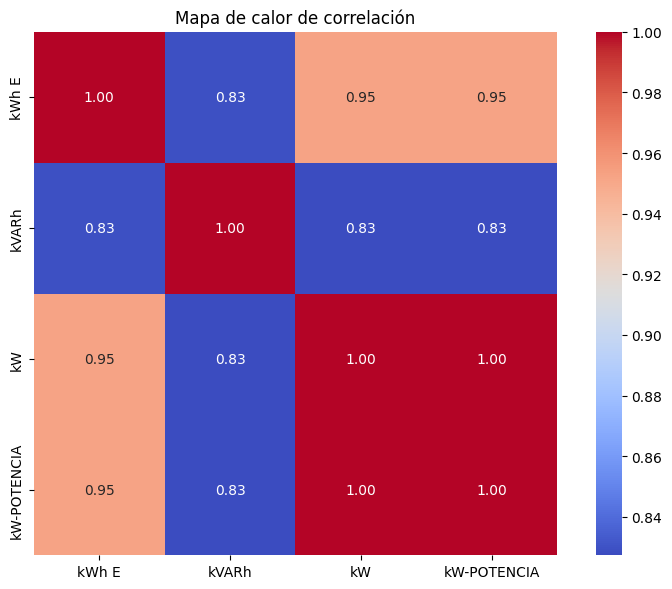

In [4]:
# Calcular la matriz de correlación
correlation_matrix = energy_df[['kWh E', 'kVARh', 'kW', 'kW-POTENCIA']].corr()

# Crear un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Mapa de calor de correlación')
plt.tight_layout()
plt.show()

Los coeficientes de correlación del parámetro target kWh E con los parámetros kVARh, kW y kW-POTENCIA, son bastante altos y positivos, con valores cercanos a 0.8 o superiores. Esto indica una correlación lineal fuerte y positiva entre las variables. Confirmando que estas pueden ser descartadas para el análisis que se realizará

In [5]:
# Listado columnas a borrar
delete_columns = ["kVARh", "kW", "kW-POTENCIA"]
# borramos columnas
energy_df = energy_df.drop(delete_columns, axis=1)
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569087 entries, 0 to 569086
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   kWh E      569087 non-null  float64       
 1   Fecha HR   569087 non-null  datetime64[ns]
 2   NombreDia  569087 non-null  object        
 3   MES        569087 non-null  object        
 4   Año        569087 non-null  int64         
 5   HORA       569087 non-null  int64         
 6   MINUTO     569087 non-null  object        
 7   CLIENTE    569087 non-null  object        
 8   Año-Mes    569087 non-null  object        
 9   Fecha      569087 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 43.4+ MB


#### 🗓️ Parametros de fecha

Borramos las columnas ["MES", "AÑO", "HORA", "MINUTO", "AÑO-MES", "FECHA","NombreDia"] futuros analisis, podrian ser extraidos de parametro Fecha HR, ademas de que estos pueden estar en formatos dificiles de manipular.

In [6]:
# Listado columnas a borrar
delete_columns = ["MES", "Año", "HORA", "MINUTO", "Año-Mes", "Fecha", 'NombreDia']
# borramos columnas
energy_df = energy_df.drop(delete_columns, axis=1)
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569087 entries, 0 to 569086
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   kWh E     569087 non-null  float64       
 1   Fecha HR  569087 non-null  datetime64[ns]
 2   CLIENTE   569087 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 13.0+ MB


### Conversion tipos de datos

- `Fecha HR`: datetime.
- `CLIENTE`: Variable categórica nominal
- `KWh E`: Variable objetivo, flotante.


In [7]:
energy_df['Fecha HR'] = pd.to_datetime(energy_df['Fecha HR'])
energy_df['CLIENTE'] = energy_df['CLIENTE'].astype("category")
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569087 entries, 0 to 569086
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   kWh E     569087 non-null  float64       
 1   Fecha HR  569087 non-null  datetime64[ns]
 2   CLIENTE   569087 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(1)
memory usage: 9.2 MB


#### 💾 Guardar nuevo Data Set

In [8]:
schema = pa.Table.from_pandas(energy_df).schema
energy_df.to_parquet( '../data/interim/energy_modify_dataset.parquet',
                    index=False,
                    schema=schema
)

In [9]:
energy_df.to_csv('../data/interim/energy_modify_dataset.csv', index=False)

___

/tmp/ipykernel_4792/2017666784.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=energy_df, x='Fecha HR', y='kVARh', hue='CLIENTE', ci=None)


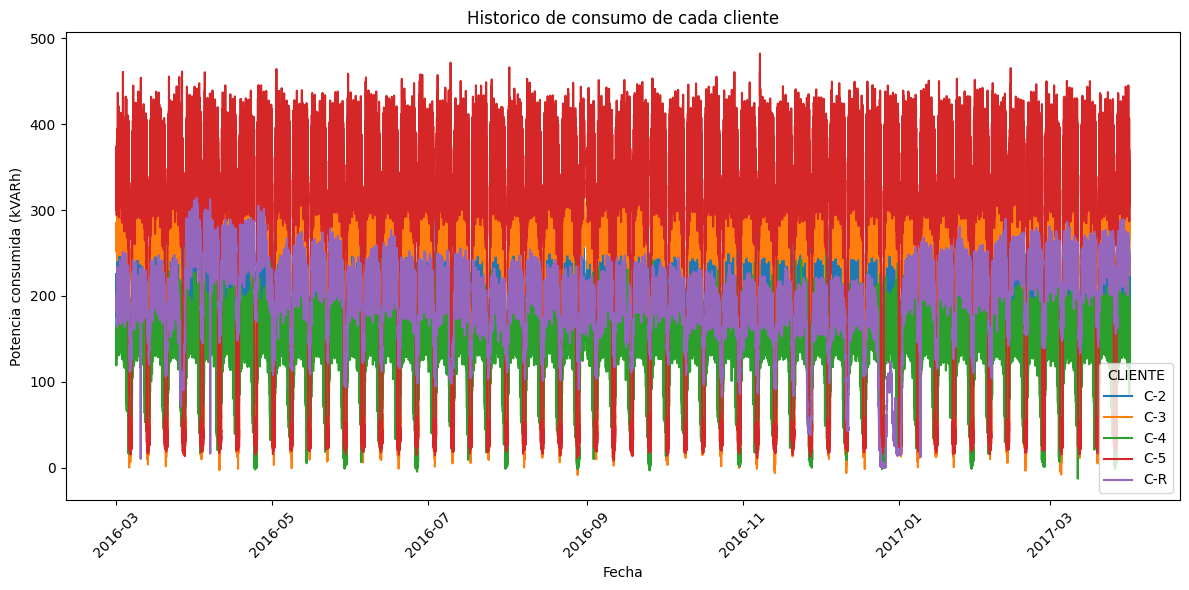

In [11]:
# Plot historical energy consumption for each customer
plt.figure(figsize=(12, 6))
sns.lineplot(data=energy_df, x='Fecha HR', y='kVARh', hue='CLIENTE', ci=None)
plt.title('Historico de consumo de cada cliente')
plt.xlabel('Fecha')
plt.ylabel('Potencia consumida (kVARh)')
plt.xticks(rotation=45)  # Rotar etiquetas del eje x para mayor legibilidad
plt.tight_layout()
plt.show()

/tmp/ipykernel_4792/2808721337.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=consumo_promedio_por_mes, x='Mes', y='kVARh', hue='CLIENTE', ci=None)


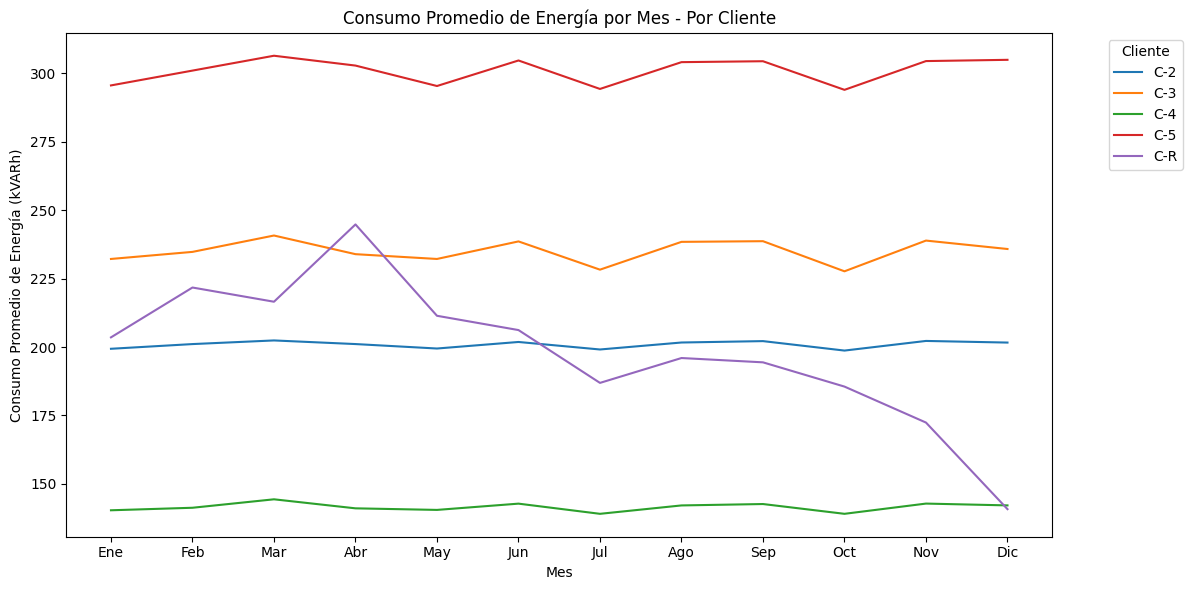

In [12]:
# Convertir la columna 'Fecha HR' a tipo datetime si aún no lo está
energy_df['Fecha HR'] = pd.to_datetime(energy_df['Fecha HR'])

# Agregar una nueva columna 'Mes' que contenga el mes de cada registro
energy_df['Mes'] = energy_df['Fecha HR'].dt.month

# Calcular el consumo promedio por mes de cada usuario
consumo_promedio_por_mes = energy_df.groupby(['CLIENTE', 'Mes'])['kVARh'].mean().reset_index()
# Graficar el consumo promedio por mes de cada usuario
plt.figure(figsize=(12, 6))
sns.lineplot(data=consumo_promedio_por_mes, x='Mes', y='kVARh', hue='CLIENTE', ci=None)
plt.title('Consumo Promedio de Energía por Mes - Por Cliente')
plt.xlabel('Mes')
plt.ylabel('Consumo Promedio de Energía (kVARh)')
plt.xticks(range(1, 13), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
plt.legend(title='Cliente', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

/tmp/ipykernel_4792/1488591807.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=consumo_promedio_por_dia_semana, x='DiaSemana', y='kVARh', hue='CLIENTE', ci=None, hue_order=energy_df['CLIENTE'].unique(), sort=False)


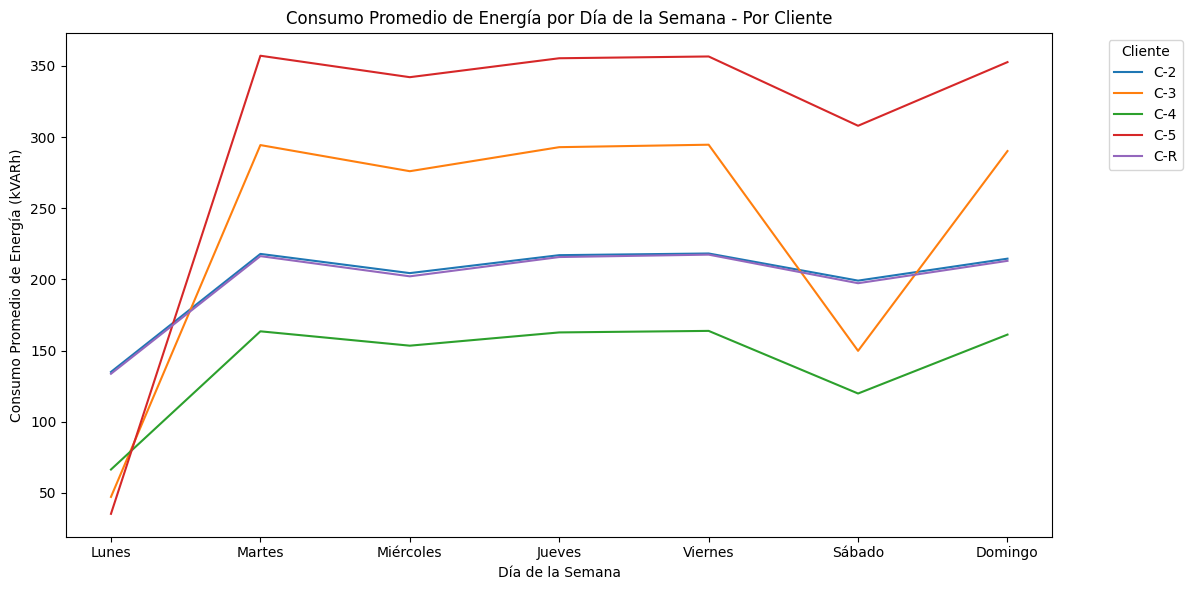

In [17]:
# Agregar una nueva columna 'DiaSemana' que contenga el día de la semana de cada registro (0 para lunes, 1 para martes, ..., 6 para domingo)
energy_df['DiaSemana'] = energy_df['Fecha HR'].dt.dayofweek

# Mapear los números de día de la semana a nombres de día y especificar el orden correcto
orden_dias_semana = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
energy_df['DiaSemana'] = energy_df['DiaSemana'].map(lambda x: orden_dias_semana[x])

# Calcular el consumo promedio por día de la semana de cada usuario
consumo_promedio_por_dia_semana = energy_df.groupby(['CLIENTE', 'DiaSemana'])['kVARh'].mean().reset_index()

# Graficar el consumo promedio por día de la semana de cada usuario
plt.figure(figsize=(12, 6))
sns.lineplot(data=consumo_promedio_por_dia_semana, x='DiaSemana', y='kVARh', hue='CLIENTE', ci=None, hue_order=energy_df['CLIENTE'].unique(), sort=False)
plt.title('Consumo Promedio de Energía por Día de la Semana - Por Cliente')
plt.xlabel('Día de la Semana')
plt.ylabel('Consumo Promedio de Energía (kVARh)')
plt.xticks(range(len(orden_dias_semana)), orden_dias_semana)  # Establecer las etiquetas del eje x correctamente
plt.legend(title='Cliente', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


----

In [28]:
energy_df['Fecha HR'].dt.month

kWh E
342.08    3
299.35    3
332.75    3
328.34    3
342.00    3
         ..
350.49    3
359.06    3
363.96    3
355.16    3
333.65    3
Name: Fecha HR, Length: 569087, dtype: int32

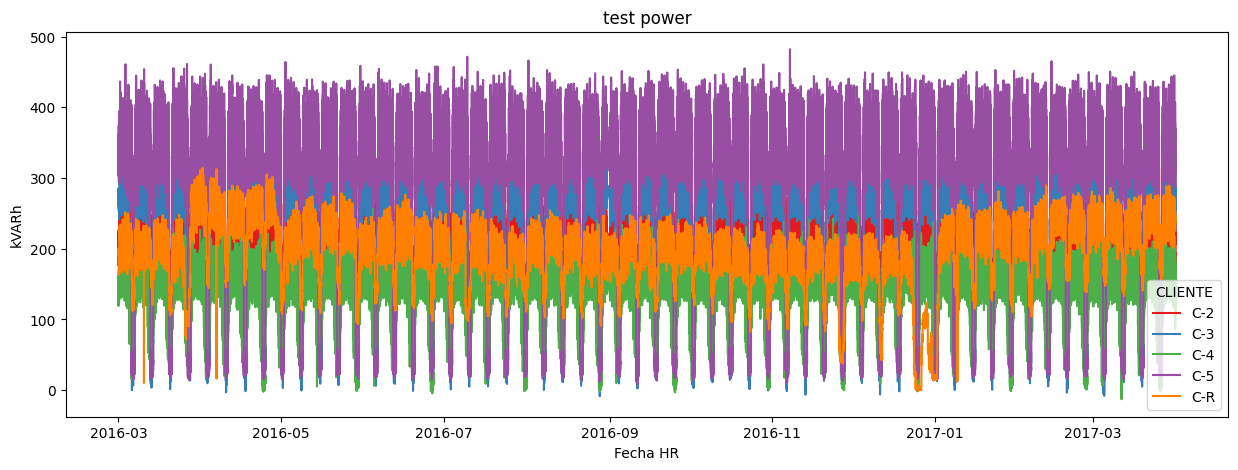

In [26]:
plt.figure(figsize=(15,5))
sns.lineplot(x='Fecha HR', y='kVARh', hue='CLIENTE', data=energy_df, palette='Set1')
plt.title('test power')
plt.show()